# TPSL: Short term dip

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ta.trend import SMAIndicator
import time

In [3]:
# Temporary solution
import sys
sys.path.insert(0, '..')
import useful_functions as uf

In [48]:
df = pd.read_csv("../data/BTCUSDT-minute.csv")

In [41]:
# df = df[1870000:1880000]

In [6]:
df.reset_index(drop=True, inplace=True)

In [7]:
for i,c in enumerate(df['close']):
    acc = []

In [43]:
def get_target(df, span:int, tp:float, sl:float):
    """
    gets target. must have tp or greater within span and no sl in span
    tp: 1.5
    sl: 2.5
    """
    acc = [] #target column

    for i in range(len(df["close"])):
        close = df.iloc[i].close
        high = df.iloc[i].high
        low = df.iloc[i].low
        
        if i+span < len(df["close"]):
            tp_price = (1+tp/100)*close
            sl_price = (1-sl/100)*close
            high = max(df.iloc[i+1:i+span].high)
            low = min(df.iloc[i+1:i+span].low)
            
            if low<sl_price:
                acc.append(0)
            elif high>tp_price:
                acc.append(1)
            else:
                acc.append(0)
        else:
            acc.append(None)

    return acc
    

In [49]:
def get_target_faster(df, span:int, tp:float, sl:float):
    target = []
    sdf = df[['close','high', 'low']]
#     c_high = max(sdf['high'][0:span])
    for i in range(sdf.shape[0]):
        
        #progress tracker
        if i %100000 == 0:
            print('█', end="")
        
        if i+span >= len(sdf['close']): 
            target.append(None)
            continue
            
        close = sdf['close'][i]
        high = sdf['high'][i]
        low = sdf['low'][i]
        tp_price = (1+tp/100)*close
        sl_price = (1-sl/100)*close
        
        peak = max(sdf['high'][i+1:i+span])
        end = [x for x in df.index[df['high'] == peak].tolist() if x>=i+1][0] #allow dip to be below sl if after this point
        dip = min(sdf['low'][i+1:end+1])

        target.append(1 if peak>tp_price and dip>sl_price else 0)
    
    print(' DONE')
    return target

In [19]:
start_time = time.time()
df["target1"] = get_target(df, span=200, tp=1.5, sl=2.5)
print("--- %s seconds ---" % (time.time() - start_time))

--- 25.742660760879517 seconds ---


In [50]:
start_time = time.time()
df["target"] = get_target_faster(df, span=1000, tp=3, sl=3)
print("--- %s seconds ---" % (time.time() - start_time))

████████████████████ DONE
--- 6404.66450715065 seconds ---


In [37]:
df["scatter_target"] = list(map(lambda x, c: c if x == 1 else None, df["target"], df["close"]))

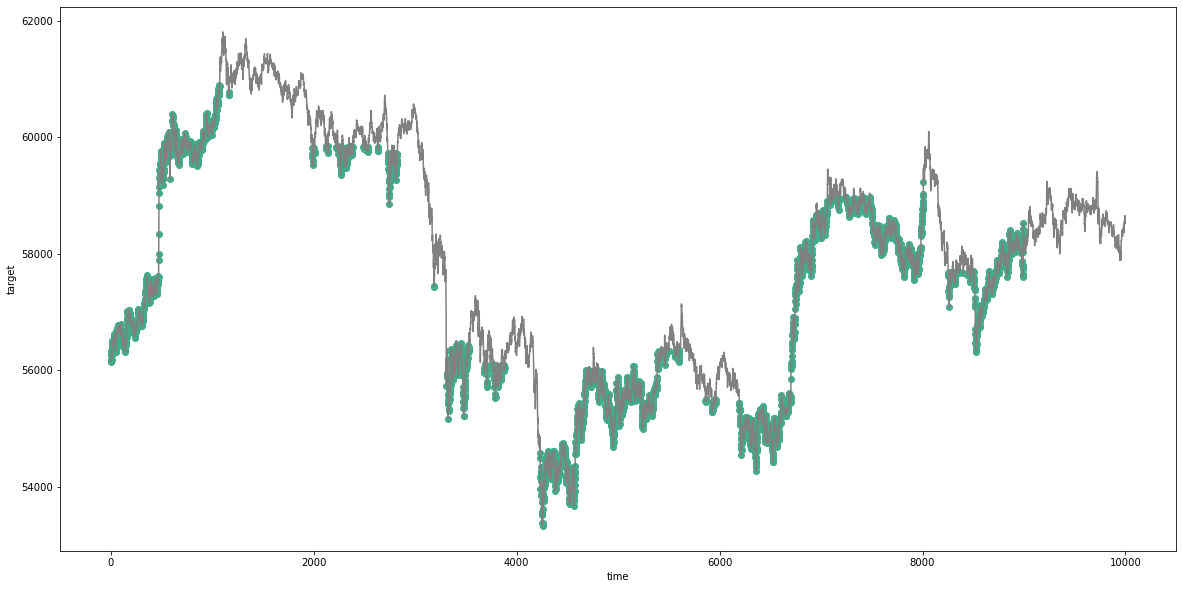

In [38]:
d = df[0:10000]

fig,ax = plt.subplots(figsize=(20, 10))
ax.scatter(range(len(d)),
           d.scatter_target,
            color="#43aa8b")
# ax.axhline(y=0, color='darkgreen', linestyle='-')
ax.set_xlabel("time")
ax.set_ylabel("target")

# ax.tick_params(labelbottom=False)    
# ax.axes.xaxis.set_visible(False)

# ax2=ax.twinx()
ax.plot(list(d.close),
         color="grey")

# ax.set_ylabel("close")
# fig.legend(["a", "b", "c", "d"])
plt.show()

In [64]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objects as go

In [121]:
# d = df[1000000:]
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=d.index, y=d['close'], name='close'))
# fig.add_trace(go.Scatter(x=d.index, y=d['scatter_target'], name='target'))

# fig.show()

In [51]:
df.target.value_counts(), df.target.value_counts()[1]/(df.target.value_counts()[0]+df.target.value_counts()[1])

(0.0    1494980
 1.0     492758
 Name: target, dtype: int64,
 0.24789886795945945)

In [52]:
df.to_csv("../data/BTCUSDT-minute-target-tpsl.csv", index=False)